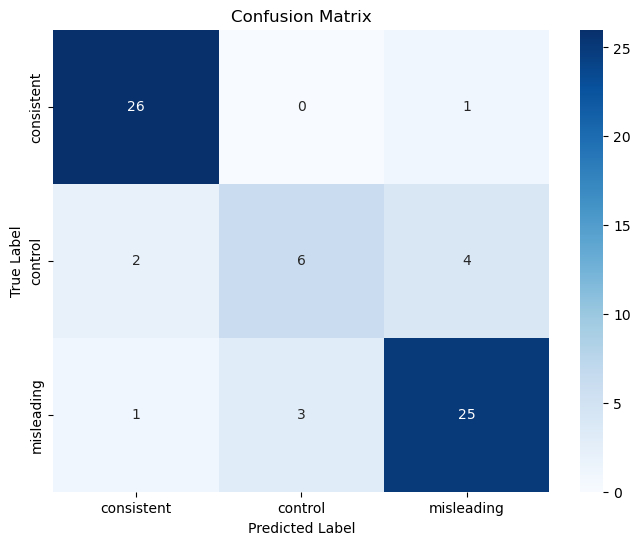

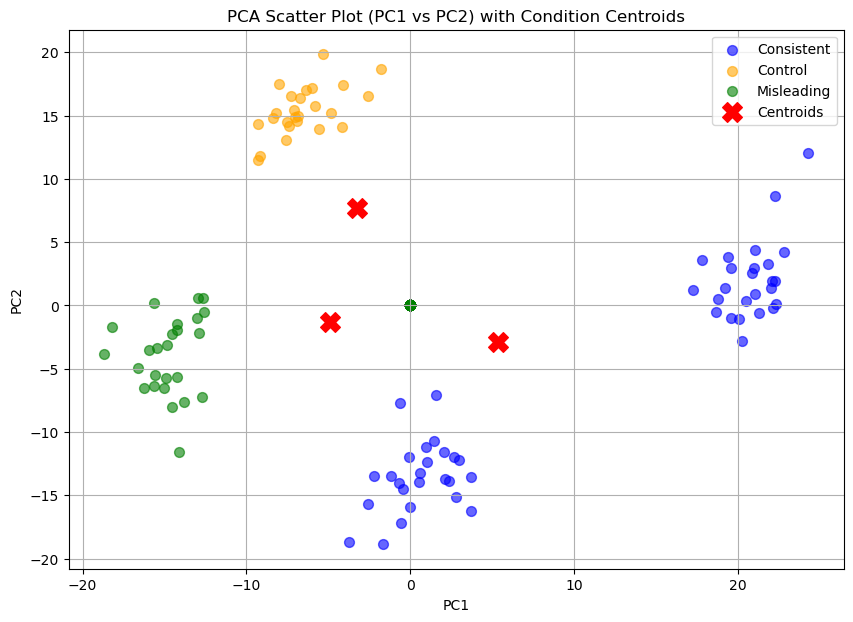

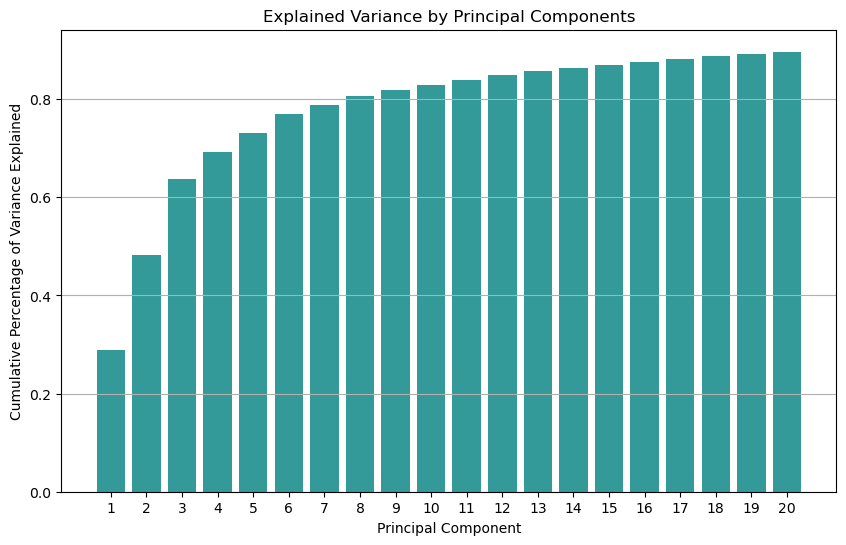

PC1: Accounts for the majority of variance, showing clear separation of 'consistent' and 'misleading'.
PC2: Captures secondary patterns, aiding in distinguishing 'control' conditions.
Overall: The first two components effectively separate conditions, confirming PCA's utility for dimensionality reduction.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import f_oneway

# Load datasets dynamically 
file_paths = {
    "ALLTRIALS150275.csv": "ALLTRIALS150275.csv",
    "ALLTRIALS150350.csv": "ALLTRIALS150350.csv",
    "ALLTRIALS250400.csv": "ALLTRIALS250400.csv",
    "ALLTRIALS300500.csv": "ALLTRIALS300500.csv",
    "ALLTRIALS550800.csv": "ALLTRIALS550800.csv",
    "Peaks_FN400.csv": "Peaks_FN400.csv",
    "Peaks_N2.csv": "Peaks_N2.csv",
    "Peaks_P2.csv": "Peaks_P2.csv",
    "Peaks_P3.csv": "Peaks_P3.csv"
}

# Load datasets into a dictionary
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Assign meaningful labels to conditions
label_mapping = {
    "ALLTRIALS150275.csv": "consistent",
    "ALLTRIALS150350.csv": "consistent",
    "ALLTRIALS250400.csv": "control",
    "ALLTRIALS300500.csv": "misleading",
    "ALLTRIALS550800.csv": "misleading",
    "Peaks_FN400.csv": "consistent",
    "Peaks_N2.csv": "control",
    "Peaks_P2.csv": "misleading",
    "Peaks_P3.csv": "consistent"
}

# Generate labels for combined datasets
labels = []
for name, df in datasets.items():
    condition = label_mapping.get(name, "unknown")
    labels.extend([condition] * len(df))

# Numeric mapping for labels
label_numeric_mapping = {"consistent": 0, "control": 1, "misleading": 2}
numeric_labels = [label_numeric_mapping[label] for label in labels]

# Add filenames as metadata to combined datasets
combined_data = pd.concat(
    [df.assign(Source=name) for name, df in datasets.items()], axis=0, ignore_index=True
)

# Preprocess data (exclude irrelevant columns, normalize, and impute)
def preprocess_features(df):
    df_cleaned = df.loc[:, ~df.columns.str.contains('Fp1', case=False)]
    numeric_data = df_cleaned.select_dtypes(include=[np.number])
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    processed = scaler.fit_transform(imputer.fit_transform(numeric_data))
    return pd.DataFrame(processed, columns=numeric_data.columns)

preprocessed_data = preprocess_features(combined_data)

# Apply PCA
pca = PCA(n_components=20)
pca_transformed = pca.fit_transform(preprocessed_data)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Add file source and labels to PCA-transformed data
pca_df = pd.DataFrame(pca_transformed, columns=[f"PC{i+1}" for i in range(pca_transformed.shape[1])])
pca_df['Condition'] = numeric_labels
pca_df['Source'] = combined_data['Source']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_transformed, numeric_labels, test_size=0.3, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
classification = classification_report(y_test, y_pred, target_names=['consistent', 'control', 'misleading'])
confusion = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['consistent', 'control', 'misleading'],
            yticklabels=['consistent', 'control', 'misleading'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# PCA Visualization
centroids = pca_df.groupby('Condition')[['PC1', 'PC2']].mean()

# Scatter plot of PC1 vs PC2 with centroids
plt.figure(figsize=(10, 7))
for condition, label, color in zip([0, 1, 2], ['Consistent', 'Control', 'Misleading'], ['blue', 'orange', 'green']):
    condition_data = pca_df[pca_df['Condition'] == condition]
    plt.scatter(condition_data['PC1'], condition_data['PC2'], alpha=0.6, label=label, s=50, c=color)
plt.scatter(centroids['PC1'], centroids['PC2'], s=200, c='red', marker='X', label='Centroids')
plt.title('PCA Scatter Plot (PC1 vs PC2) with Condition Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid()
plt.show()

# Bar chart of explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, color='teal')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Percentage of Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y')
plt.show()

# Insights
insights = {
    "PC1": "Accounts for the majority of variance, showing clear separation of 'consistent' and 'misleading'.",
    "PC2": "Captures secondary patterns, aiding in distinguishing 'control' conditions.",
    "Overall": "The first two components effectively separate conditions, confirming PCA's utility for dimensionality reduction."
}

for key, value in insights.items():
    print(f"{key}: {value}")
